# Dx score - pedsAML only

```{contents}
```

## Load data

In [1]:
import pandas as pd
import sys
sys.path.append('../')
from source.pacmap_functions import *

input_path = '../../Data/Intermediate_Files/'
output_path = '../../Data/Processed_Data/'

# read df_discovery and df_validation
df_discovery = pd.read_pickle(
    input_path+'3330samples-333351cpgs-nobatchcorrection-bvalues.pkl').sort_index()

df_validation = pd.read_pickle(
    input_path+'201samples-357839cpgs-withbatchcorrection-bvalues.pkl').sort_index()

# Load clinical data
discovery_clinical_data = pd.read_csv(input_path+'discovery_clinical_data.csv',
                                      low_memory=False, index_col=0)

# Load clinical data
validation_clinical_data = pd.read_csv(input_path+'validation_clinical_data.csv',
                                        low_memory=False, index_col=0)

# Adjust clinical data
discovery_clinical_data['Train Test'] = 'Discovery (train) Samples'
validation_clinical_data['Train Test'] = 'Validation (test) Samples'

discovery_clinical_data['PaCMAP Output'] = 'Patient Samples'
validation_clinical_data['PaCMAP Output'] = 'Patient Samples'

discovery_clinical_data['Batch'] = df_discovery['Batch']
validation_clinical_data['Batch'] = 'St Jude Children\'s'


## Select CpGs in both train and test

In [2]:
# use overlapping features between df_discovery and df_validation
common_features = [x for x in df_discovery.columns if x in df_validation.columns]

# apply `common_features` to both df_discovery and df_validation
df_discovery = df_discovery[common_features]
df_validation = df_validation[common_features]

print(
f' Discovery dataset (df_discovery) contains {df_discovery.shape[1]} \
columns (5mC nucleotides/probes) and {df_discovery.shape[0]} rows (samples).')

print(
f' Validation dataset (df_validation) contains {df_validation.shape[1]} \
columns (5mC nucleotides/probes) and {df_validation.shape[0]} rows (samples).')

output_notebook()

# Set the theme for the plot
curdoc().theme = 'light_minimal' # or 'dark_minimal'

 Discovery dataset (df_discovery) contains 319738 columns (5mC nucleotides/probes) and 3330 rows (samples).
 Validation dataset (df_validation) contains 319738 columns (5mC nucleotides/probes) and 201 rows (samples).


Loading BokehJS ...

## The Methylome Atlas of Acute Leukemia

In [3]:
clinical_trials = [
                    # 'NOPHO ALL92-2000', 
                    'AAML0531',
                    'AAML1031',
                    # 'Beat AML Consortium',
                    # 'TCGA AML',
                    # 'CETLAM SMD-09 (MDS-tAML)',
                    # 'French GRAALL 2003–2005',
                    # 'TARGET ALL',
                    'AAML03P1',
                    'Japanese AML05',
                    'CCG2961']

sample_types = ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow',
                'Bone Marrow Normal','Primary Blood Derived Cancer - Peripheral Blood',
                'Blood Derived Normal','Likely Diagnosis', 'Control (Healthy Donor)',
                # 'Relapse','Recurrent Blood Derived Cancer - Bone Marrow',
                # 'Recurrent Blood Derived Cancer - Peripheral Blood',
                'Peripheral Blood Normal']

cols = ['Clinical Trial', 'Sample Type', 'Patient_ID', 'ELN AML 2022 Diagnosis', 'Train Test', 'Batch', 'Hematopoietic Group']

components = [2,5]
for n in components:
    processor = DataProcessor(discovery_clinical_data.copy(),
                              df_discovery,
                              clinical_trials,
                              sample_types,
                              cols, 
                              n_components=n,
                              common_prefix=output_path+f'pacmap_output/pacmap_{n}d_model_acute_leukemia', 
                              df_test=df_validation.copy(),
                              test_clinical_data=validation_clinical_data.copy())
    
    processor.filter_data()
    processor.apply_pacmap() # learn PaCMAP on the training data
    processor.apply_pacmap_test() # apply PaCMAP to the test data
    processor.join_labels()

    # Save output
    processor.df.to_csv(output_path+f'pacmap_output/pacmap_{n}d_output_acute_leukemia.csv')


df = pd.read_csv(output_path+'pacmap_output/pacmap_2d_output_acute_leukemia.csv', index_col=0)

The PaCMAP instance is successfully saved at ../../Data/Processed_Data/pacmap_output/pacmap_2d_model_acute_leukemia.pkl.
To load the instance again, please do `pacmap.load(../../Data/Processed_Data/pacmap_output/pacmap_2d_model_acute_leukemia)`.
The PaCMAP instance is successfully saved at ../../Data/Processed_Data/pacmap_output/pacmap_5d_model_acute_leukemia.pkl.
To load the instance again, please do `pacmap.load(../../Data/Processed_Data/pacmap_output/pacmap_5d_model_acute_leukemia)`.


In [4]:
# Concatenate discovery and validation clinical data
clinical_data = pd.concat([discovery_clinical_data, validation_clinical_data]).loc[df['index']]

# Select columns to plot
cols = ['PaCMAP Output','Hematopoietic Group','WHO 2022 Diagnosis','WHO AML 2022 Diagnosis',
        'WHO ALL 2022 Diagnosis','ELN AML 2022 Diagnosis','Age (group years)', 'Batch', 'Sex',
        'Clinical Trial', 'Sample Type', 'Train Test']

# Join clinical data to the embedding
df = df.join(clinical_data[cols], rsuffix='_copy', on='index')

# Call the BokehPlotter class to plot the data
plotter = BokehPlotter(df, cols, get_custom_color_palette(), 
                       title='The Methylome Atlas of Acute Leukemia',
                       x_range=(-40, 40), y_range=(-50, 50),
                       datapoint_size=3, width=1000, height=500)
plotter.plot()

## Patient Characteristics Table

In [5]:
from tableone import TableOne

columns = ['Hematopoietic Group','Age (group years)','Sex',
            'Clinical Trial',]

df_train = df[df['Train Test']=='Discovery (train) Samples']

mytable_cog = TableOne(df_train.reset_index(), columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Age (group years)':['0-5','5-13','13-39','39-60'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

# mytable_cog.to_excel('data/tableone_Dx_pacmap.xlsx')
# mytable_cog.to_csv(output_path + 'pacmap_output/tableone_Dx_pacmap.csv')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",'Missing','Discovery','Validation','p-value','Statistical Test']
                        )

'<table>\n<thead>\n<tr><th>                          </th><th>                                          </th><th>Overall   </th></tr>\n</thead>\n<tbody>\n<tr><td>n                         </td><td>                                          </td><td>1138      </td></tr>\n<tr><td>Hematopoietic Group, n (%)</td><td>Acute myeloid leukemia (AML)              </td><td>754 (85.6)</td></tr>\n<tr><td>                          </td><td>Acute promyelocytic leukemia (APL)        </td><td>1 (0.1)   </td></tr>\n<tr><td>                          </td><td>Myelodysplastic syndrome (MDS or MDS-like)</td><td>15 (1.7)  </td></tr>\n<tr><td>                          </td><td>Otherwise-Normal (Control)                </td><td>111 (12.6)</td></tr>\n<tr><td>Age (group years), n (%)  </td><td>0-5                                       </td><td>382 (33.6)</td></tr>\n<tr><td>                          </td><td>5-13                                      </td><td>370 (32.5)</td></tr>\n<tr><td>                          </td><td>13-39                                     </td><td>386 (33.9)</td></tr>\n<tr><td>Sex, n (%)                </td><td>Female                                    </td><td>568 (49.9)</td></tr>\n<tr><td>                          </td><td>Male                                      </td><td>570 (50.1)</td></tr>\n<tr><td>Clinical Trial, n (%)     </td><td>AAML03P1                                  </td><td>58 (5.1)  </td></tr>\n<tr><td>                          </td><td>AAML0531                                  </td><td>592 (52.0)</td></tr>\n<tr><td>                          </td><td>AAML1031                                  </td><td>397 (34.9)</td></tr>\n<tr><td>                          </td><td>CCG2961                                   </td><td>27 (2.4)  </td></tr>\n<tr><td>                          </td><td>Japanese AML05                            </td><td>64 (5.6)  </td></tr>\n</tbody>\n</table>'

## Load data for multi-class classifier

In [6]:
import pandas as pd
import numpy as np

input_path = '../../Data/Intermediate_Files/'
output_path = '../../Data/Processed_Data/'

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Select ELN 2022 annotated samples

In [7]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_original = df.copy()
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

# print the number of samples dropped and the amount remaining
print(df_original.shape[0]-df.shape[0], 'samples removed.'\
, df.shape[0], 'samples remaining.')

348 samples removed. 991 samples remaining.


### Select Dx subtypes with at least 10 samples

In [15]:
print(df['ELN AML 2022 Diagnosis'].value_counts(dropna=False))

# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df2 = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1',
                                       'APL with t(15;17)(q24.1;q21.2)/PML::RARA',
                                       'AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement'])]

# print the number of samples dropped and the amount remaining
print(df.shape[0]-df2.shape[0], 'samples removed.'\
, df2.shape[0], 'samples remaining, which includes 110 test samples')
                                       

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           263
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                163
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             146
AML with other rare recurring translocations                              138
Otherwise-Normal Control                                                  111
AML with mutated NPM1                                                      88
AML with in-frame bZIP mutated CEBPA                                       38
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     23
MDS-related or secondary myeloid neoplasms                                 15
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement      5
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                    1
Name: count, dtype: int64
6 samples removed. 985 samples remaining, which includes 110 test samples


### Define X and y

In [16]:

# Define X and y
X = df2[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df2['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df2['Train Test']=='Discovery (train) Samples']
y_train = y[df2['Train Test']=='Discovery (train) Samples']
X_test = X[df2['Train Test']=='Validation (test) Samples']
y_test = y[df2['Train Test']=='Validation (test) Samples']

# print the number of samples in each set
print('X_train shape:', X_train.shape, 'X_test shape:', X_test.shape)

X_train shape: (875, 5) X_test shape: (110, 5)


In [17]:
df2['ELN AML 2022 Diagnosis'].value_counts(dropna=False)

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                  263
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                       163
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11    146
AML with other rare recurring translocations                     138
Otherwise-Normal Control                                         111
AML with mutated NPM1                                             88
AML with in-frame bZIP mutated CEBPA                              38
AML with t(6;9)(p23;q34.1)/DEK::NUP214                            23
MDS-related or secondary myeloid neoplasms                        15
Name: count, dtype: int64

## LightGBM

Best parameters: {'learning_rate': 0.1, 'n_estimators': 30, 'num_leaves': 50}
Best cross-validation score: 0.963
Overall accuracy score with best estimator: 0.864


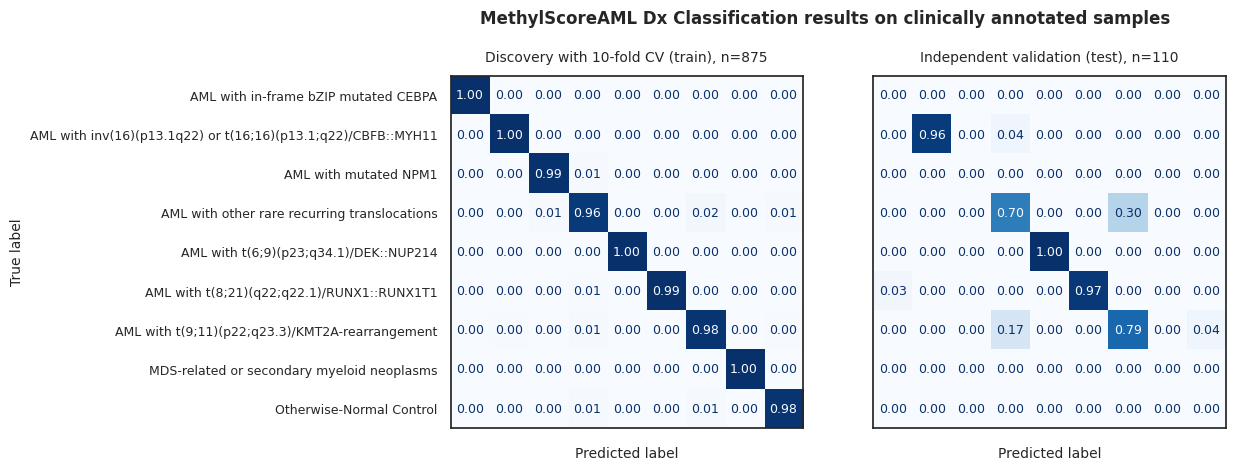

In [19]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from source.data_visualization_functions import plot_confusion_matrix_stacked

# Define the parameter grid
param_grid = {
    'num_leaves': [30, 50, 100], # number of leaves in full tree, which will roughly be the same as max number of features in one-hot encoding
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # learning rate
    'n_estimators': [15 ,30, 50, 100, 200],  # number of trees (or rounds)
}

# Initialize the LGBM Classifier
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


```{note}
Due to low sample size, the following classes were removed:
    - 'APL with t(15;17)(q24.1;q21.2)/PML::RARA', n=1
    - 'AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement', n=5
```

## Watermark

In [12]:
%load_ext watermark

In [13]:
# watermark with all libraries used in this notebook
%watermark -v -p numpy,pandas,bokeh,pacmap,itables -a Francisco_Marchi@Lamba_Lab_UF -d -m

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy  : 1.24.3
pandas : 2.0.2
bokeh  : 3.1.1
pacmap : 0.7.0
itables: 1.5.2

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

